# Local CpGs characterisation 
- CpGs highly connected to latent features
- Biggest question: WHY are they grouped together? 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle 
import torch
from data.prepareData import prepareDataLoader_fromPkl
from scripts.train_RFregressor import RFregression
import random
import copy

from scipy.stats import pearsonr
import json

from scipy.stats import mannwhitneyu

sns.set_theme(style="ticks", font_scale=1.4)

In [2]:
PATH_results_local = f"results/localCpGs"
os.makedirs(f"{PATH_results_local}", exist_ok = True)

In [3]:
PATH_data = "/data/scratch/skatz/PROJECTS/methylnet"
def loadData():
    df_manifest = pd.read_csv(f"{PATH_data}/humanmethylation450_15017482_v1-2.csv", skiprows=7, low_memory=False, header=0, index_col="IlmnID")
    #df_manifest = df_manifest[df_manifest["CHR"] == "22"]
    return df_manifest

# Investigate if local CpGs share latent features due to...

## ... 1. common genomic context?

In [2]:
''' 
This one only runs locally... not feasible maybe
'''

# !/usr/lib/R/bin/Rscript scipts/GOenrirch.R results/finalModels/chr22/perturbations/cpgs_high.txt
#!python associationPipeline_chr22.py --cpgfile results/optLatSize/latSize_25/perturbations/latFeature_0/cpgs_high.txt

''' 
Run in external script (bash script) as it takes some time. 
- adjust in script: chromosome number and latent feature count
'''
# %%bash
# ./scripts/run_pipeline.sh

' \nRun in external script (bash script) as it takes some time. \n- adjust in script: chromosome number and latent feature count\n'

In [8]:
def get_summary_AssociationAna(context, CHR, cpgs_sel = "cpgs_high"):
    
    path = f"results/{CHR}/perturbations"
    latFeatures = [i for i in os.listdir(f"{path}") if i.startswith("latFeature")]

    dic = dict()
    for latFeature_i in latFeatures:
        df = pd.read_csv(f"{path}/{latFeature_i}/{cpgs_sel}/AssociationSummary.csv", index_col=0)

        df_tmp = df[df["context"] == context]
        keys = df_tmp[df_tmp["pval"] < 0.05].index
        for i in keys:
            if i in dic.keys():
                dic[i].append(latFeature_i) 
            else: 
                dic[i] = [latFeature_i]
    #dic_chrWide[CHR] = dic
    return dic

### Genomic context
dic_chrWide = dict()
for CHR in [f"chr{i}" for i in range(1,23)]: #### CHANGE
    dic_inner = dict()
    for context in ["relativeGene", "regulatoryFeature", "relativeIsland", "DHS", "Enhancer"]:
        dic_inner[context] = get_summary_AssociationAna(context, CHR, cpgs_sel="cpgs_high") 
    dic_chrWide[CHR] = dic_inner   

In [9]:
'''
Sum up significant associations over all latent features (chromosome-wide)
'''
sum_embedding = dict()
for CHR in [f"chr{i}" for i in range(1,23)]:
    for key0 in dic_chrWide[CHR].keys():
        for key1 in dic_chrWide[CHR][key0].keys():
            sigContexts = len(dic_chrWide[CHR][key0][key1])
            if f"{key0}_{key1}" in sum_embedding.keys(): 
                sum_embedding[f"{key0}_{key1}"]+=sigContexts
            else: 
                sum_embedding[f"{key0}_{key1}"]=sigContexts
sum_embedding   

{'relativeGene_TSS1500': 299,
 'relativeGene_1stExon': 305,
 "relativeGene_3'UTR": 223,
 "relativeGene_5'UTR": 586,
 'relativeGene_Body': 861,
 'regulatoryFeature_Gene_Associated_Cell_type_specific': 14,
 'DHS_True': 383,
 'DHS_False': 146,
 'Enhancer_True': 622,
 'regulatoryFeature_NonGene_Associated': 3,
 'relativeGene_TSS200': 55,
 'regulatoryFeature_NonGene_Associated_Cell_type_specific': 18,
 'regulatoryFeature_Unclassified_Cell_type_specific': 3,
 'relativeIsland_N_Shore': 17,
 'Enhancer_False': 222,
 'relativeIsland_Island': 13,
 'relativeIsland_S_Shelf': 19,
 'regulatoryFeature_Gene_Associated': 4,
 'relativeIsland_N_Shelf': 26,
 'regulatoryFeature_Promoter_Associated_Cell_type_specific': 31,
 'relativeIsland_S_Shore': 9}

In [15]:
df_res = pd.DataFrame.from_dict(sum_embedding, orient="index").sort_values(0, ascending=False)
df_res.to_csv(f"{PATH_results_local}/genomic_association.csv",header=False)

df_res

,0
relativeGene_Body,861
Enhancer_True,622
relativeGene_5'UTR,586
DHS_True,383
relativeGene_1stExon,305
relativeGene_TSS1500,299
relativeGene_3'UTR,223
Enhancer_False,222
DHS_False,146
relativeGene_TSS200,55


## ... 2. spatially close to each other inside of latent features 
##          (LD-blocks)?

In [140]:
df_manifest = loadData()

for CHR in [f"chr{i}" for i in range(1,23)]:
    path = f"results/{CHR}/perturbations"
    latFeatures = [i for i in os.listdir(f"{path}") if i.startswith("latFeature")]
    dic_dist = dict()
    for latFeature in latFeatures:
        ### Load CpGs
        cpgfile = f"results/{CHR}/perturbations/{latFeature}/cpgs_high.txt"
        cpglist =  pd.read_csv(os.path.join(cpgfile), header=None)[0].tolist()
        
        ### Get genomic location and distances to each other
        df = df_manifest.loc[cpglist,:].copy()
        pos_latFeature = df["MAPINFO"].sort_values().tolist()  

        ### save
        dic_dist[latFeature] = pos_latFeature
    with open(f'{path}/genomicDistance_allLatFeatures.json', 'w') as fp: json.dump(dic_dist, fp, indent=4, sort_keys=True)       

## Analysis

In [4]:
''' pairwise distance '''
from sklearn.metrics import pairwise_distances
def calc_pairwiseDis(x,y):
    return (y-x)

### Calculation sparsity ratio

In [5]:
def calc_sparsity(cpglist, ld_cutoff=0.25*10**6, verbose=True): 
    ''' 
    Function to calculate the LD sparsity ratio of CpGs (CpGs not in LD / all CpGs) 
    LD-cutoff is per default 250kB
    '''
    ## 1. Get pairwise distances (upper triangle of matrix with residual values as nan)
    cpglist_pairwiseDis = np.triu(pairwise_distances(cpglist.reshape(-1,1), metric=calc_pairwiseDis))
    cpglist_pairwiseDis = np.where(cpglist_pairwiseDis==0, np.nan, cpglist_pairwiseDis)
    
    ### 2. Get which CpGs are in LD (below LD-cutoff)
    ld_matrix = np.full([len(cpglist), len(cpglist)], np.nan)
    ld_matrix[cpglist_pairwiseDis <= ld_cutoff] = 1
    ld_matrix[cpglist_pairwiseDis > ld_cutoff] = 0
    ld_flatten = ld_matrix[~np.isnan(ld_matrix)]

    #### 3. Calculate sparsity ratio (CpGs not in LD / all CpGs)
    cpg_ld = np.count_nonzero(ld_flatten)
    cpg_not_ld = len(ld_flatten) - cpg_ld
    sparsity_ratio = cpg_not_ld / len(ld_flatten)
    if verbose: 
        print(f"LD: {cpg_ld}\t\tTotal: {len(ld_flatten)}\tSparsity ratio: {sparsity_ratio}")
    return sparsity_ratio

In [6]:
dic_sparsity = dict()
for CHR in [f"chr{i}" for i in range(1,23)]:      
    ### Load genomic distances
    path = f"results/{CHR}/perturbations"
    with open(f'{path}/genomicDistance_allLatFeatures.json', 'r') as fp: dic_dist = json.load(fp)
    all_spars = []
    for latFeature, cpglist in dic_dist.items():
        ### 0. Load My CpG list of interest 
        cpglist = np.array(cpglist)
        all_spars.append(calc_sparsity(cpglist, ld_cutoff=0.25*10**6, verbose=False))  ### 250 kB cutoff
    dic_sparsity[CHR] = all_spars

Text(0, 0.5, 'Sparsity Ratio')

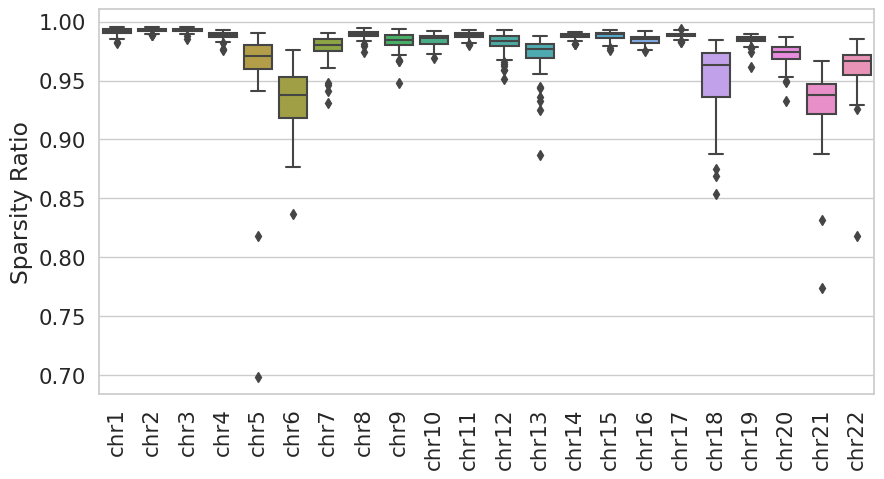

In [7]:
df_spars = pd.DataFrame.from_dict(dic_sparsity, orient="index").T

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(data=df_spars)
ax.set_xticklabels(df_spars.columns,rotation=90)
ax.set_ylabel("Sparsity Ratio")

Text(0, 0.5, 'Sparsity ratio')

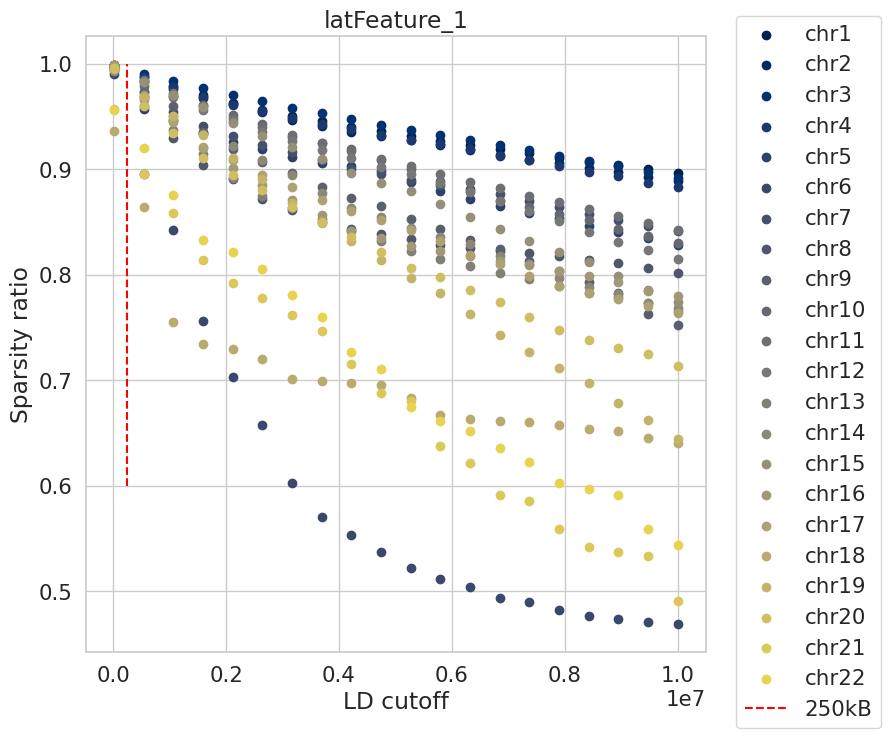

In [295]:
### Influence of LD cutoff on sparsity ratio
fig, ax = plt.subplots(figsize=(8,8))

from matplotlib import cm
viridis = cm.get_cmap('cividis', 256)
newcolors = viridis(np.linspace(0, 1, 24))

for idx, CHR in enumerate([f"chr{i}" for i in range(1,23)]):
    ### Load genomic distances
    path = f"results/{CHR}/perturbations"
    with open(f'{path}/genomicDistance_allLatFeatures.json', 'r') as fp: dic_dist = json.load(fp)
        
    latFeature = "latFeature_1"
    cpglist = np.array(dic_dist[latFeature])
    interval = np.linspace(0.01*10**6, 10*10**6, 20)
    spars = []
    for thresh in interval:
        spars.append(calc_sparsity(cpglist, ld_cutoff=thresh, verbose=False))
        
    ### Plot
    ax.scatter(interval, spars, label=CHR, color=newcolors[idx])   
    
ax.vlines(250000, 0.6, 1,linestyle="dashed", label="250kB", color="red")
ax.legend()
ax.legend(bbox_to_anchor=(1.3, 1.05))
ax.set_title(f"{latFeature}")
ax.set_xlabel("LD cutoff")
ax.set_ylabel("Sparsity ratio")

### Median of pairwise-distances [MB]

In [186]:
def calc_pairwiseDis_median(cpglist):
    cpglist_pairwiseDis = np.triu(pairwise_distances(cpglist.reshape(-1,1), metric=calc_pairwiseDis))
    cpglist_pairwiseDis = np.where(cpglist_pairwiseDis==0, np.nan, cpglist_pairwiseDis)
    cpglist_median = np.nanmedian(cpglist_pairwiseDis)
    return cpglist_median

9.606075

In [234]:
#latFeature = "latFeature_60"
dic_medianDis = dict()
for CHR in [f"chr{i}" for i in range(1,23)]:
    ### Load genomic distances
    path = f"results/{CHR}/perturbations"
    with open(f'{path}/genomicDistance_allLatFeatures.json', 'r') as fp: dic_dist = json.load(fp)
        
    ### Get median distances
    all_dis = []
    for latFeature, cpglist in dic_dist.items():
        ### 0. Load My CpG list of interest 
        cpglist = np.array(dic_dist[latFeature])
        all_dis.append(calc_pairwiseDis_median(cpglist)/10**6) ### in MB
    dic_medianDis[CHR] =  all_dis

Text(0, 0.5, 'median pairwise distance [Mb]')

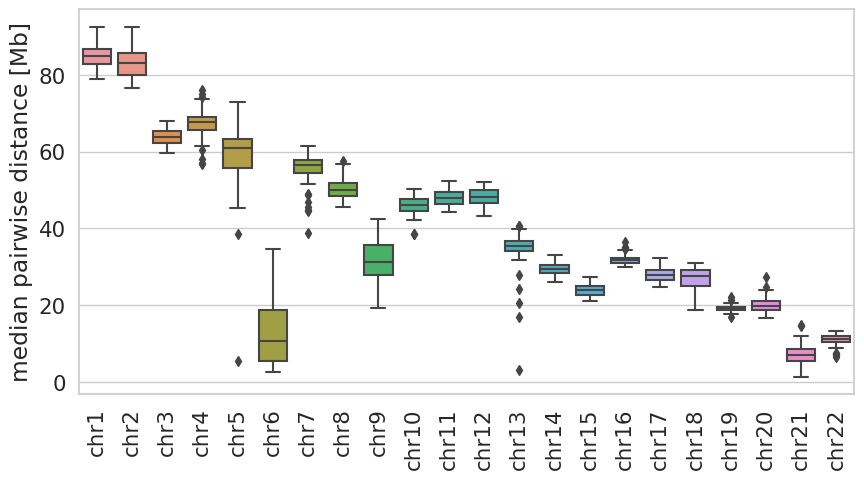

In [246]:
df = pd.DataFrame.from_dict(dic_medianDis, orient="index").T

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(data=df)
ax.set_xticklabels(df.columns,rotation=90)
ax.set_ylabel("median pairwise distance [Mb]")

316


Text(0.5, 1.0, 'chr6 - latFeature_22')

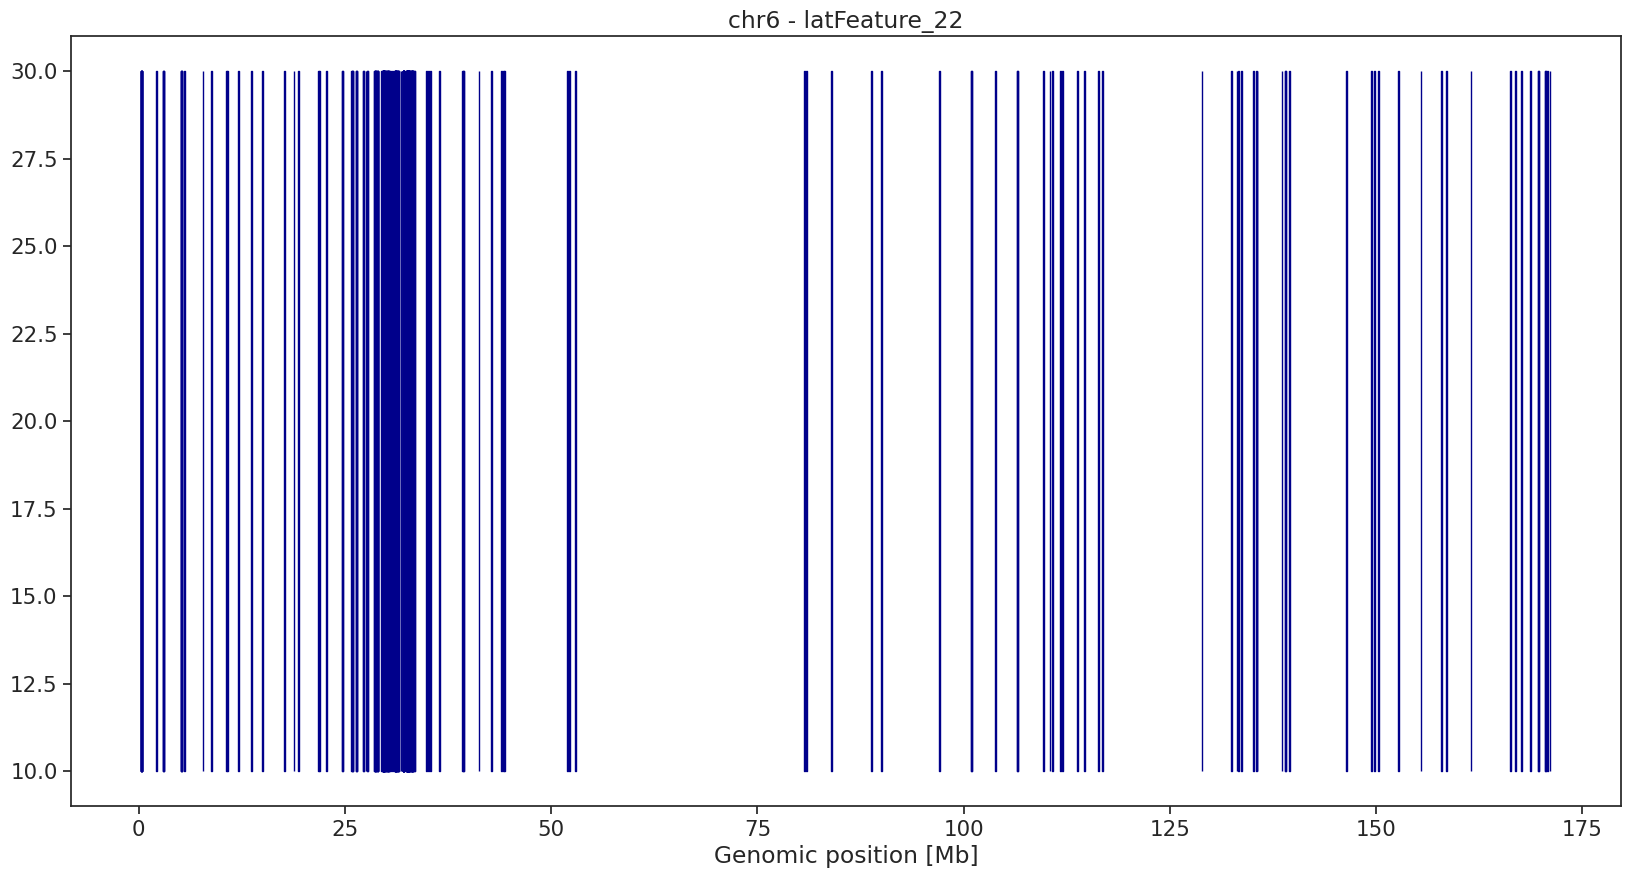

In [23]:
sns.set_theme(style="ticks", font_scale=1.4) 

#### Illustration
for CHR in [f"chr{i}" for i in range(6,7)]:      
    ### Load genomic distances
    path = f"results/{CHR}/perturbations"
    with open(f'{path}/genomicDistance_allLatFeatures.json', 'r') as fp: dic_dist = json.load(fp)
        
###
a = dic_dist["latFeature_6"]
print(len(a))
fg, ax = plt.subplots(figsize=(20,10))
ax.broken_barh([(ele/10**6,0.1) for ele in a],(10,20), color="darkblue")
ax.set_xlabel("Genomic position [Mb]")
ax.set_title(f"{CHR} - latFeature_22")

## ... 3. are afftected by meQTL site?
--> not even if its the same meQTL site, quick and dirty analysis
meQTL source: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6753136/ ; [link](https://ftp.ncbi.nlm.nih.gov/eqtl/original_submissions/FHS_meQTLs/)


- Wanted to do a more in-depth analysis of whether they are affected by the same SNPs or something similar, but analysis is complicated and I do not know how to approach it... mostly about LD pruning 

- How meaningful is this analysis? Would have to count "LD blocks" instead of individual CpGs?

In [4]:
# df_qtl_trans = pd.read_csv(f"{PATH_data}/meQTL/trans_mQTLs_exclintra5Mb.csv", index_col="CpG")
# df_qtl_trans = set(df_qtl_trans.index.unique())

# for CHR in [f"chr{i}" for i in range(1,2)]:
#     path = f"results/{CHR}/perturbations"
#     df_qtl_cis = pd.read_csv(f"{PATH_data}/meQTL/cisPe6_{CHR}_clean.csv-2e11.csv", index_col="CpG")
    
#     ### Loop over all latent feature of CHR
#     dict_trans = dict()
#     dict_cis = dict()
#     latFeatures = [i for i in os.listdir(f"{path}") if i.startswith("latFeature")][:10] ### CHANGE
#     print(latFeatures)
#     for latFeature in latFeatures:
#         ### Load CpGs
#         cpgfile = f"results/{CHR}/perturbations/{latFeature}/cpgs_high.txt"
#         cpglist =  pd.read_csv(os.path.join(cpgfile), header=None)[0].tolist()
               
#         ### trans-meQTL
#         dict_trans[latFeature] = list(df_qtl_trans & set(cpglist))
#         ### cis-meQTL
#         dict_cis[latFeature] = list(set(df_qtl_cis.index.unique()) & set(cpglist)) 
            
#     ### Save all latent features in one dict
#     with open(f'{path}/trans_meQTL_allLatFeatures.json', 'w') as fp: json.dump(dict_trans, fp, indent=4, sort_keys=True)
#     with open(f'{path}/cis_meQTL_allLatFeatures.json', 'w') as fp: json.dump(dict_cis, fp, indent=4, sort_keys=True)

['latFeature_39', 'latFeature_4', 'latFeature_38', 'latFeature_45', 'latFeature_22', 'latFeature_40', 'latFeature_28', 'latFeature_41', 'latFeature_1', 'latFeature_35']


### Analysis of how many CpGs are meQTLS 


- Wanted to do a more in-depth analysis of whether they are affected by the same SNPs or something similar, but analysis is complicated and I do not know how to approach it... mostly about LD pruning 

- How meaningful is this analysis? Would have to count "LD blocks" instead of individual CpGs?

In [21]:
# with open(f'{path}/trans_meQTL_allLatFeatures.json', 'r') as fp: trans = json.load(fp)
# with open(f'{path}/cis_meQTL_allLatFeatures.json', 'r') as fp: cis = json.load(fp)

In [81]:
# for CHR in [f"chr{i}" for i in range(1,2)]:
#     ### Load meQTLs
#     path = f"results/{CHR}/perturbations"
#     with open(f'{path}/trans_meQTL_allLatFeatures.json', 'r') as fp: trans = json.load(fp)
#     with open(f'{path}/cis_meQTL_allLatFeatures.json', 'r') as fp: cis = json.load(fp)
            
#     latFeatures = [i for i in os.listdir(f"{path}") if i.startswith("latFeature")][:10] ### CHANGE
#     for latFeature in latFeatures:
#         ### Number of CpGs in total
#         cpgfile = f"results/{CHR}/perturbations/{latFeature}/cpgs_high.txt"
#         len_cpglist = len(pd.read_csv(os.path.join(cpgfile), header=None)[0])
        
#         ### All high cpgs of Chr1 that are meQTLs
#         trans1= trans[latFeature]
#         cis1 = cis[latFeature]
#         ### Number of meQTLs
#         meqtl1 = list(set(cis1+trans1))
#         print(latFeature, len(meqtl1), len_cpglist)

latFeature_39 162 408
latFeature_4 170 339
latFeature_38 194 393
latFeature_45 133 284
latFeature_22 208 428
latFeature_40 252 552
latFeature_28 200 418
latFeature_41 171 345
latFeature_1 185 390
latFeature_35 213 413


## ... 4. same correlation pattern (linear, monotonic)?
- Pearson & spearman correlation of CpGs within the same latent feature
- final value: `mean()` of `mean() & std()` CpG cross correation; (`double mean()`! watch out maybe?)



In [9]:
### Load data (all patients!)
PATH_betaVals = "/data/scratch/skatz/PROJECTS/methylnet/1_healthyVAE/data/GSE87571/train_val_test_sets/"

df_betaVals = pd.DataFrame()
for ds in ["train", "test", "val"]:
    with open(os.path.join(PATH_betaVals, f"{ds}_methyl_array.pkl"), "rb") as f: train_dataset = pickle.load(f)     ##### CHANGED THIS FROM TEST TO TRAINING
    train_tensor = torch.tensor(train_dataset["beta"].values, dtype=torch.float32)
    df_orig = train_dataset["beta"]
    df_betaVals = pd.concat([df_betaVals, df_orig], axis=0)
    
df_betaVals.shape

(720, 300000)

In [31]:
for CHR in [f"chr{i}" for i in range(1,23)]:    
    ### Load perturbation groups
    path = f"results/{CHR}/perturbations"
    latFeatures = [i for i in os.listdir(f"{path}") if i.startswith("latFeature")]
    
    dic_corr_pearson = dict()
    dic_corr_spear = dict()
    for latFeature in latFeatures:
        ### Load CpGs
        cpgfile = f"results/{CHR}/perturbations/{latFeature}/cpgs_high.txt"
        cpglist =  pd.read_csv(os.path.join(cpgfile), header=None)[0].tolist()
        
        ### Get beta values of those CpGs
        df = df_betaVals.loc[:,cpglist].copy()

        ### Get pearson correlation
#         corr_pearson = df.corr(method='pearson').copy()
#         np.fill_diagonal(corr_pearson.values, np.nan)  
#         dic_corr_pearson[latFeature] = [corr_pearson.mean(axis=0).mean(), corr_pearson.std(axis=0).mean()]
        
        ### Get spearman correlation
        corr_spear = df.corr(method='spearman').copy()
        np.fill_diagonal(corr_spear.values, np.nan)  
        
        dic_corr_spear[latFeature] = np.nanmedian(corr_spear)
        
    #with open(f'{path}/correlation_pearson_allLatFeatures.json', 'w') as fp: json.dump(dic_corr_pearson, fp, indent=4, sort_keys=True)       
    with open(f'{path}/correlation_spearman_allLatFeatures.json', 'w') as fp: json.dump(dic_corr_spear, fp, indent=4, sort_keys=True)       
        

### Analysis

In [32]:
df_pearson_allChr = pd.DataFrame()
df_spear_allChr = pd.DataFrame()

for CHR in [f"chr{i}" for i in range(1,23)]:
    ### Load genomic distances
    path = f"results/{CHR}/perturbations"
    
#     ### Pearson
#     with open(f'{path}/correlation_pearson_allLatFeatures.json', 'r') as fp: dic_pearson = json.load(fp)
#     df_corr_pearson = pd.DataFrame.from_dict(dic_pearson, orient="index")
#     df_pearson_allChr = pd.concat([df_pearson_allChr, df_corr_pearson], ignore_index=True)
    
    ### Spearman
    with open(f'{path}/correlation_spearman_allLatFeatures.json', 'r') as fp: dic_spear = json.load(fp)
    df_corr_spear = pd.DataFrame.from_dict(dic_spear, orient="index")
    df_spear_allChr = pd.concat([df_spear_allChr, df_corr_spear], ignore_index=True)
    
#df_pearson_allChr.columns = ["mean", "std"]
df_spear_allChr.columns = ["median"]

Text(0, 0.5, '')

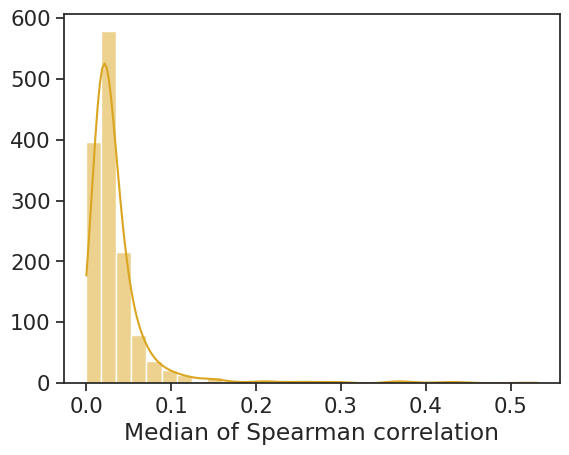

In [41]:
### Distribtuion of mean & std across CpGs belonging to same lat feature
# fig, ax = plt.subplots()
# sns.histplot(df_pearson_allChr.loc[:,"mean"], kde=True, bins=20, color="green")
# ax.set_xlabel("mean() of pearson correlation \nbetween CpGs in same latent feature")
# ax.set_ylabel("")

fig, ax = plt.subplots()
sns.histplot(df_spear_allChr.loc[:,"median"], kde=True, bins=30, color="goldenrod")
ax.set_xlabel("Median of Spearman correlation")#\nbetween CpGs in same latent feature")
ax.set_ylabel("")

In [118]:
df_spear_allChr.shape

(1389, 2)

## ... 5. biological pathway? 
(not feasible to compute); can also not check 3D structure because I dont know how haha

Analysis done on EpiStat cluster `/home/skatz/PROJECTS/methAE/GO_enrich`

```
Total number of latFeatures: 1389;
total number of latFeatures with at least one GO term associated: 201,
Ratio: 14.47084233261339
```

GO terms / KEGG			
Total number of latent features	- associated with at least one GO / KEGG term - ratio [%]
chr1	72	10	13.89
chr2	60	3	5
chr3	45	2	4.44
chr4	50	1	2
chr5	38	34	89.47
chr6	78	78	100
chr7	70	0	0
chr8	88	7	7.95
chr9	88	1	1.14
chr10	52	0	0
chr11	50	12	24
chr12	52	7	13.46
chr13	90	4	4.44
chr14	48	6	12.5
chr15	48	0	0
chr16	50	6	12
chr17	60	9	15
chr18	72	0	0
chr19	60	19	31.67
chr20	88	2	2.27
chr21	60	0	0
chr22	70	0	0